In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset

import sys
sys.path.append("..")
from commands.configs import (
    BYTE_DATA_NGRAM_EXTRACTION,
    BYTELEVEL_TOK_FOLDER,
    FINEWEBEDU_REPO_ID,
    HF_USERNAME,
    TOK_REPO_ID,
)

from torch import Tensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from commands.configs import BYTE_LLM_PREDICTION_DATA, COMMONCORPUS_REPO_ID

byte_data = load_dataset(f"{HF_USERNAME}/{FINEWEBEDU_REPO_ID}", BYTE_LLM_PREDICTION_DATA)['fw57M']

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

In [64]:
# # Get language=Spanish
# for item in byte_data:
#     if item['language'] == 'Spanish':
#         example = item
#         break
example = byte_data[8]
print(byte_level_tokenizer.decode(example['input_ids'][784:855]))

 Plato
hypothesizes that the elements themselves are made of particles 


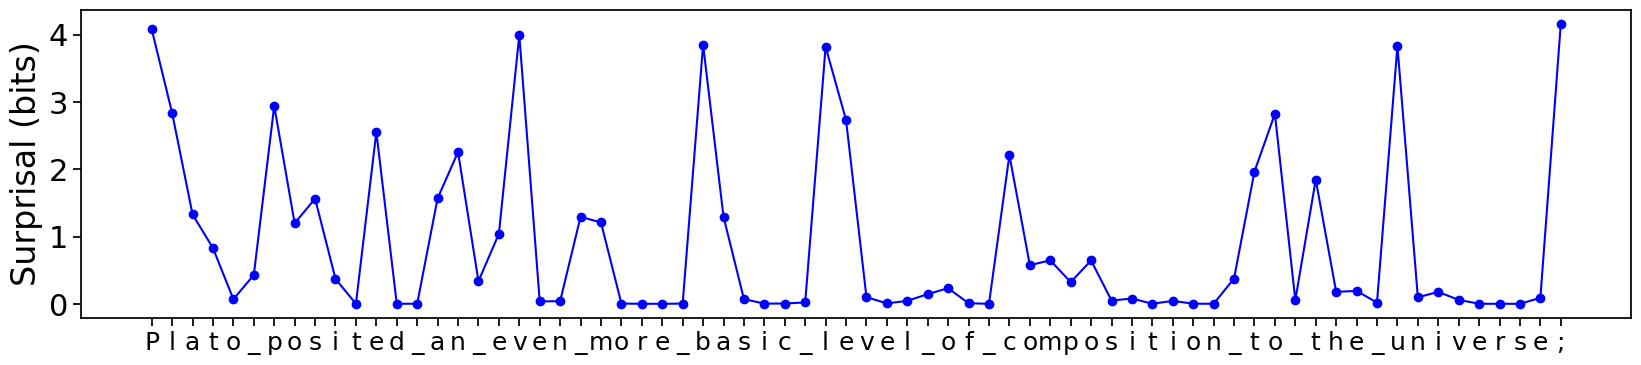

In [6]:
byte_level_tokenizer = AutoTokenizer.from_pretrained(f"{HF_USERNAME}/{TOK_REPO_ID}", subfolder=BYTELEVEL_TOK_FOLDER)

# Plot example

i = 575
j = 645
cue = 'Surprisal'

signal = Tensor(example[cue][i:j])

# font size
sns.set_context("notebook", font_scale=2)

plt.figure(figsize=(20, 4))
# input_ids on x-axis, surprisal on y-axis
plt.plot(list(range(j-i)), signal, marker='o', linestyle='-', color='b')
plt.ylabel(cue + ' (bits)')
# Set x tick labels to decoded
decoded = [byte_level_tokenizer.decode(inp) for inp in example['input_ids']]
decoded = ['_' if d == ' ' else d for d in decoded]
plt.xticks(list(range(j-i)), decoded[i:j], ha='center', fontsize=18)
plt.show()


In [7]:
import json
import logging
import shutil
from pathlib import Path
from typing import Annotated

import pandas as pd
import torch
import typer
from datasets import Dataset, load_dataset
from huggingface_hub import HfApi, logging as hf_logging
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, processors, trainers
from tqdm import tqdm
from transformers import AutoTokenizer, PreTrainedTokenizerFast

from commands.configs import (
    BYTE_LLM_PREDICTION_DATA,
    BYTELEVEL_TOK_FOLDER,
    FINEWEBEDU_REPO_ID,
    HF_USERNAME,
    TOK_REPO_ID,
)
from commands.extract import SUPPORTED_MODELS
from src.utilities import get_logger

app = typer.Typer()

ADD_PREFIX_SPACE = True  # Note that we will add a prefix_space to the pre_tokenizer
PAD_TOKEN = "<|padding|>"
EOS_TOKEN = "<|endoftext|>"
UNK_TOKEN = "<|unk|>"
DEFAULT_TOKENIZER_SIZES = [8_064, 16_000, 32_000, 64_000, 128_000, 256_000]

# Create logger
logger = get_logger("tokenizer")
hf_logging.set_verbosity_info()  # or _debug for more info

In [38]:
from collections import defaultdict

class ThresholdTokenizerTrainer:

    def __init__(
        self,
        dataset: Dataset,
        byte_tokenizer: PreTrainedTokenizerFast,
        measure: str,
        include_space: bool = False,
        keep_intermediate_vocab: bool = True,
        frequency_threshold: int = None,
        logger: logging.Logger = None,
    ) -> None:
        """Class for training a threshold-based tokenizer using information measures derived from a byte-level LM.

        Args:
            dataset (Dataset): The dataset to use for training containing information measures for each token.
            byte_tokenizer (ByteLevelBPETokenizer): The byte-level tokenizer to use for the initial vocabulary.
            measure (str): The information measure to use ('Entropy', 'Surprisal', etc.).
            include_space (bool, optional): Whether to include space in the vocabulary.
            keep_intermediate_vocab (bool, optional): Whether to keep intermediate vocabularies during training.
            frequency_threshold (int, optional): Frequency threshold for tokens to be included in the vocabulary.
            logger (logging.Logger, optional): Logger for debugging and information.
        """
        if measure not in dataset.column_names:
            raise ValueError(f"Measure '{measure}' not found in dataset columns.")

        self.byte_tokenizer = byte_tokenizer
        self.include_space = include_space
        self.keep_intermediate_vocab = keep_intermediate_vocab
        self.frequency_threshold = frequency_threshold
        self.logger = logger if logger else get_logger("tokenizer")

        self.eos_token_id = byte_tokenizer.eos_token_id
        self.pad_token_id = byte_tokenizer.pad_token_id
        self.space_token_id = byte_tokenizer.encode(' ')[0]
        if self.eos_token_id is None:
            raise ValueError("Byte tokenizer must have an EOS token.")
        self.device = torch.device("cpu") # for some reason cpu is faster than cuda

        # Convert byte vocab to be compatible with wordpiece
        self.base_vocab = byte_tokenizer.get_vocab()
        keys = list(self.base_vocab.keys())
        for key in keys:
            if key != PAD_TOKEN and key != EOS_TOKEN:
                self.base_vocab['##' + key] = len(self.base_vocab)
        self.base_vocab[UNK_TOKEN] = len(self.base_vocab)
        self.vocab = self.base_vocab.copy()
        self.segment_counts = defaultdict(int)

        # Create ids and signal tensors for processing
        self.logger.info("Creating ids and signal tensors...")
        eos_token = torch.tensor([self.eos_token_id], dtype=torch.int64).to(self.device)
        inf_value = torch.tensor([1e9], dtype=torch.float32).to(self.device)
        self.ids = torch.cat(
            [torch.cat([torch.tensor(x, dtype=torch.int64).to(self.device), eos_token]) for x in dataset["input_ids"]]
        )
        self.signal = torch.cat(
            [torch.cat([torch.tensor(x, dtype=torch.float32).to(self.device), inf_value]) for x in dataset[measure]]
        )
        self.total_tokens = len(self.ids)

        self.logger.info("Ids and signal tensors created.")

        # Set all EOS, UNK and PAD tokens to large value to prevent them from being included within tokens
        self.signal[self.ids == self.eos_token_id] = inf_value
        self.signal[self.ids == byte_tokenizer.unk_token_id] = inf_value
        self.signal[self.ids == byte_tokenizer.pad_token_id] = inf_value

        # if not self.include_space:
        #     self.signal[self.ids == self.space_token_id] = inf_value

        self.logger.info("Sorting signal tensor for threshold training...")

        # Track the left and right boundaries of the segments
        self.left_boundaries = torch.zeros_like(self.signal, dtype=torch.int64) - 1
        self.right_boundaries = torch.zeros_like(self.signal, dtype=torch.int64) - 1
        self.start_of_word = (self.ids == self.space_token_id).roll(1)
        self.sorted_indices = torch.argsort(self.signal)
        self.current_minimum_idx = 0

        self.logger.info("Signal tensor sorted.")

        self.stats = pd.DataFrame(columns=["num_moves", "vocab_size", "unique_segments", "threshold"])
    
    def update_vocab(self):
        self.vocab = self.base_vocab.copy()
        vocab_size = len(self.vocab)
        discovered = sorted(self.segment_counts.items(), key=lambda x: x[1], reverse=True)
        for token_ref, count in discovered:
            if count < 20:
                break
            is_start_of_word, token_ids = token_ref
            token = byte_level_tokenizer.decode(token_ids)
            if not is_start_of_word:
                token = "##" + token
            if not token in self.vocab:
                self.vocab[token] = vocab_size
                vocab_size += 1

    def train(self, final_vocab_size):
        # Initialize tqdm progress bar
        pbar = tqdm(total=final_vocab_size, desc="Building vocabulary", unit="items")

        while self.current_minimum_idx < self.total_tokens:
            min_idx = self.sorted_indices[self.current_minimum_idx]

            # Update left and right boundaries
            if min_idx > 0 and self.left_boundaries[min_idx-1] != -1:
                left_boundary = self.left_boundaries[min_idx-1]
            else:
                left_boundary = min_idx
            if min_idx < self.total_tokens - 1 and self.right_boundaries[min_idx+1] != -1:
                right_boundary = self.right_boundaries[min_idx+1]
            else:
                right_boundary = min_idx
            # Might only need left_boundaries[right_boundary] = left_boundary 
            # and right_boundaries[left_boundary] = right_boundary 
            # since we only every check the edges of segments 
            self.left_boundaries[left_boundary:right_boundary+1] = left_boundary
            self.right_boundaries[left_boundary:right_boundary+1] = right_boundary

            # Create hashable subword
            seg = self.ids[left_boundary:right_boundary + 1]
            seg_tuple = tuple(seg.tolist())
            is_start = self.ids[left_boundary-1] == self.space_token_id
            token_ref = (bool(is_start), seg_tuple)

            self.segment_counts[token_ref] += 1

            if not self.keep_intermediate_vocab:
                # Decrease counts for the tokens we merged with
                if left_boundary != min_idx:
                    prev_token_ref = (bool(is_start), tuple(self.ids[left_boundary:min_idx].tolist()))
                    self.segment_counts[prev_token_ref] = max(0, self.segment_counts[prev_token_ref] - 1)
                if right_boundary != min_idx:
                    next_token_ref = (False, tuple(self.ids[min_idx + 1:right_boundary + 1].tolist()))
                    self.segment_counts[next_token_ref] = max(0, self.segment_counts[next_token_ref] - 1)

            if self.current_minimum_idx % 1000 == 0:
                self.update_vocab()
                vocab_size = len(self.vocab)
                unique_segments = len(self.segment_counts)
                self.stats = pd.concat(
                    [self.stats,
                     pd.DataFrame([[self.current_minimum_idx,
                                    vocab_size,
                                    unique_segments,
                                    self.signal[self.sorted_indices[self.current_minimum_idx]].item()]],
                                    columns=self.stats.columns)],
                    ignore_index=True
                )
                # print(f"Step {i}: Vocab size: {vocab_size}, Unique segments: {unique_segments}, Threshold: {signal[sorted_indices[i]].item()}")
                pbar.update(vocab_size - pbar.n)
                pbar.refresh()
                if vocab_size > final_vocab_size:
                    self.logger.info(f"Final vocab size {vocab_size} exceeds target {final_vocab_size}.")
                    self.logger.info("Filtering discovered tokens by frequency.")
                    self.vocab = {k : v for k, v in self.vocab.items() if v < final_vocab_size}
                    vocab_size = len(self.vocab)
                if vocab_size >= final_vocab_size:
                    self.logger.info(f"Final vocab size reached: {vocab_size}")
                    return self.vocab
            
            self.current_minimum_idx += 1
                
    def create_tokenizer(self) -> PreTrainedTokenizerFast:
        """Create a WordPiece tokenizer using the trained vocabulary.
        Returns:
            PreTrainedTokenizerFast: The subword WordPiece-like tokenizer with custom vocabulary.
        """
        tokenizer = Tokenizer(models.WordPiece(vocab=self.vocab, unk_token=UNK_TOKEN))
        tokenizer.normalizer = normalizers.Sequence([normalizers.NFD()])
        if not self.include_space:
            tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
        else:
            # Bogus pre-tokenizer to avoid splitting, treats all input as a single token initially
            tokenizer.pre_tokenizer = pre_tokenizers.PreTokenizer()
        tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
        tokenizer.decoder = decoders.ByteLevel()

        wrapped_tokenizer = PreTrainedTokenizerFast(
            tokenizer_object=tokenizer,
            pad_token=PAD_TOKEN,
            unk_token=UNK_TOKEN,
            bos_token=EOS_TOKEN,
            eos_token=EOS_TOKEN,
            add_prefix_space=ADD_PREFIX_SPACE,
        )

        return wrapped_tokenizer

In [87]:
byte_data_subset = byte_data.select(range(1000))

trainer = ThresholdTokenizerTrainer(
    dataset=byte_data_subset,
    byte_tokenizer=byte_level_tokenizer,
    measure="Space Probability",
    include_space=False,
    frequency_threshold=20,
    logger=logger,
)

[2025-05-13 18:01:41,558][tokenizer][INFO] - Creating ids and signal tensors...
[2025-05-13 18:01:46,709][tokenizer][INFO] - Ids and signal tensors created.
[2025-05-13 18:01:46,729][tokenizer][INFO] - Sorting signal tensor for threshold training...
[2025-05-13 18:01:47,354][tokenizer][INFO] - Signal tensor sorted.


In [88]:
trainer.train(600)

Building vocabulary:   0%|          | 0/600 [00:00<?, ?items/s]/tmp/ipykernel_1192150/193581475.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stats = pd.concat(
Building vocabulary: 601items [01:00,  3.71items/s]                          [2025-05-13 18:02:47,876][tokenizer][INFO] - Final vocab size 601 exceeds target 600.
[2025-05-13 18:02:47,876][tokenizer][INFO] - Filtering discovered tokens by frequency.
[2025-05-13 18:02:47,877][tokenizer][INFO] - Final vocab size reached: 600
Building vocabulary: 601items [01:00,  9.94items/s]


{'Ĕ': 210,
 'H': 41,
 'Ð': 142,
 '$': 5,
 '<|endoftext|>': 1,
 'f': 71,
 'æ': 164,
 'â': 160,
 'p': 81,
 'ı': 239,
 'Û': 153,
 'w': 88,
 'Ě': 216,
 'ę': 215,
 'ć': 197,
 'Ē': 208,
 'Ê': 136,
 '"': 3,
 'j': 75,
 'ç': 165,
 'a': 66,
 '*': 11,
 '`': 65,
 'ģ': 225,
 '%': 6,
 'û': 185,
 'İ': 238,
 'ú': 184,
 '¥': 100,
 '8': 25,
 'ì': 170,
 'µ': 115,
 'Č': 202,
 'ĕ': 211,
 'Ø': 150,
 'Į': 236,
 'O': 48,
 '.': 15,
 '×': 149,
 'ã': 161,
 '÷': 181,
 'Ł': 255,
 'L': 45,
 '¼': 122,
 '¡': 96,
 'Ë': 137,
 '[': 60,
 '@': 33,
 'ò': 176,
 'Ą': 194,
 '}': 94,
 'ĳ': 241,
 '_': 64,
 'Ĝ': 218,
 '®': 108,
 'h': 73,
 'Y': 58,
 '{': 92,
 '½': 123,
 'Ö': 148,
 'ĝ': 219,
 'õ': 179,
 'ł': 256,
 'Ý': 155,
 '2': 19,
 '+': 12,
 '¾': 124,
 '^': 63,
 'º': 120,
 'P': 49,
 'ħ': 229,
 'ė': 213,
 '\\': 61,
 'x': 89,
 '5': 22,
 '²': 112,
 'þ': 188,
 '1': 18,
 '/': 16,
 'A': 34,
 'y': 90,
 'F': 39,
 '¢': 97,
 '¹': 119,
 'ċ': 201,
 'Ď': 204,
 'Ñ': 143,
 'Ğ': 220,
 '¸': 118,
 'ķ': 245,
 'ī': 233,
 'U': 54,
 'Ì': 138,
 'ğ': 

In [89]:
tokenizer = trainer.create_tokenizer()
tokenizer.tokenize("hello there")

['h', '##e', '##l', '##l', '##o', 't', '##h', '##e', '##r', '##e']

In [90]:
for lim in range(0, len(trainer.signal), 50):
    if 'Plato' in byte_level_tokenizer.decode(trainer.ids[lim:lim+50]):
        print(lim)
        break

43550


tensor(28)
{'##Pl': 1, '##\nhypot': 1, '##s t': 1, '## t': 1, '## ': 1, '##l': 1, '##ts th': 1, '##ms': 1, '## ar': 1, '## ma': 1, '##e ': 1, '## pa': 1, '##i': 1, '##s': 1}
tensor([ 0,  2,  5, 11, 17, 20, 23, 25, 27, 28, 29, 30, 34, 39, 40, 42, 47, 50,
        51, 54, 55, 57, 59, 62, 64, 65, 68, 69])


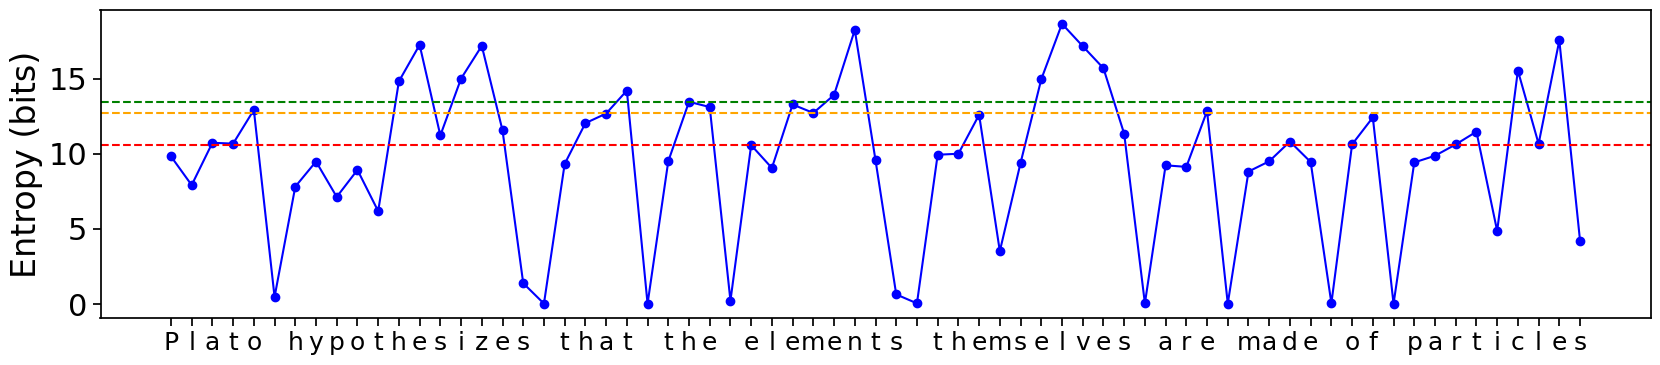

In [92]:
from collections import defaultdict

lim = 43550+210
lim2 = 43619+210
j = 35
# lim = 43550
# lim2 = 43619
# j = 35

signal = trainer.signal[lim:lim2]
ids = trainer.ids[lim:lim2]
#signal[ids == trainer.space_token_id] = 10
tokens = [byte_level_tokenizer.decode([token]) for token in ids]
sorted_indices = torch.argsort(signal)
threshold = signal[sorted_indices[j]].item()
threshold2 = signal[sorted_indices[j+15]].item()
threshold3 = signal[sorted_indices[j+20]].item()
print(sorted_indices[j])

plt.figure(figsize=(20, 4))
plt.plot(signal.cpu().numpy(), marker='o', linestyle='-', color='b')
plt.xticks(list(range(lim2-lim)), tokens, ha='center', fontsize=18)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.axhline(y=threshold2, color='orange', linestyle='--')
plt.axhline(y=threshold3, color='green', linestyle='--')
# Force bounding box to align with y axis
#plt.ylim(0, 4)
# Add vertical line whenever the signal crosses the threshold
# for i in range(len(signal)-1):
#     if (signal[i] >= threshold):
#         plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)
# for i in range(len(signal)-1):
#     if (ids[i] == trainer.space_token_id):
#         plt.axvline(x=i, color='green', linestyle='--', alpha=0.5)

plt.ylabel('Entropy (bits)')

joined_tokens = []
current_token = ""
valid_mask = signal < threshold
start_of_word = (ids == trainer.space_token_id).roll(1)
change = valid_mask[1:] != valid_mask[:-1]
change_indices = torch.nonzero(change, as_tuple=False).squeeze(1) + 1
segment_boundaries = torch.cat([
        torch.tensor([0], device=change.device),
        change_indices,
        torch.tensor([len(signal)], device=change.device)
    ])

added_vocab = defaultdict(int)
space_token_id = trainer.space_token_id

# Only iterate over even indices (valid regions)
start_index = 0 if valid_mask[0] else 1
for i in range(start_index, len(segment_boundaries)-1, 2):
    start = segment_boundaries[i].item()
    end = segment_boundaries[i + 1].item()

    segment_ids = ids[start:end]

    # Skip if the segment is empty
    if len(segment_ids) == 0:
        continue

    if not start_of_word[start]:
        token_ref = (False, segment_ids)
    else:
        token_ref = (True, segment_ids)
    added_vocab[token_ref] += 1

final_vocab = {}
for token_ref, count in added_vocab.items():
    is_start_of_word, token_ids = token_ref
    token = byte_level_tokenizer.decode(token_ids)
    if not is_start_of_word:
        token = "##" + token
    final_vocab[token] = count

print(final_vocab)
print(segment_boundaries)


[('##t', 1), ('##m', 2), ('##e', 2), ('##om', 2), ('##ent', 1), ('##d', 1), ('##p', 2), ('##u', 1), ('##rom', 1), ('##me', 1), ('##ents', 1), ('##op', 1), ('##lp', 1), ('##nd', 1), ('##ui', 1), ('##entshop', 1)]


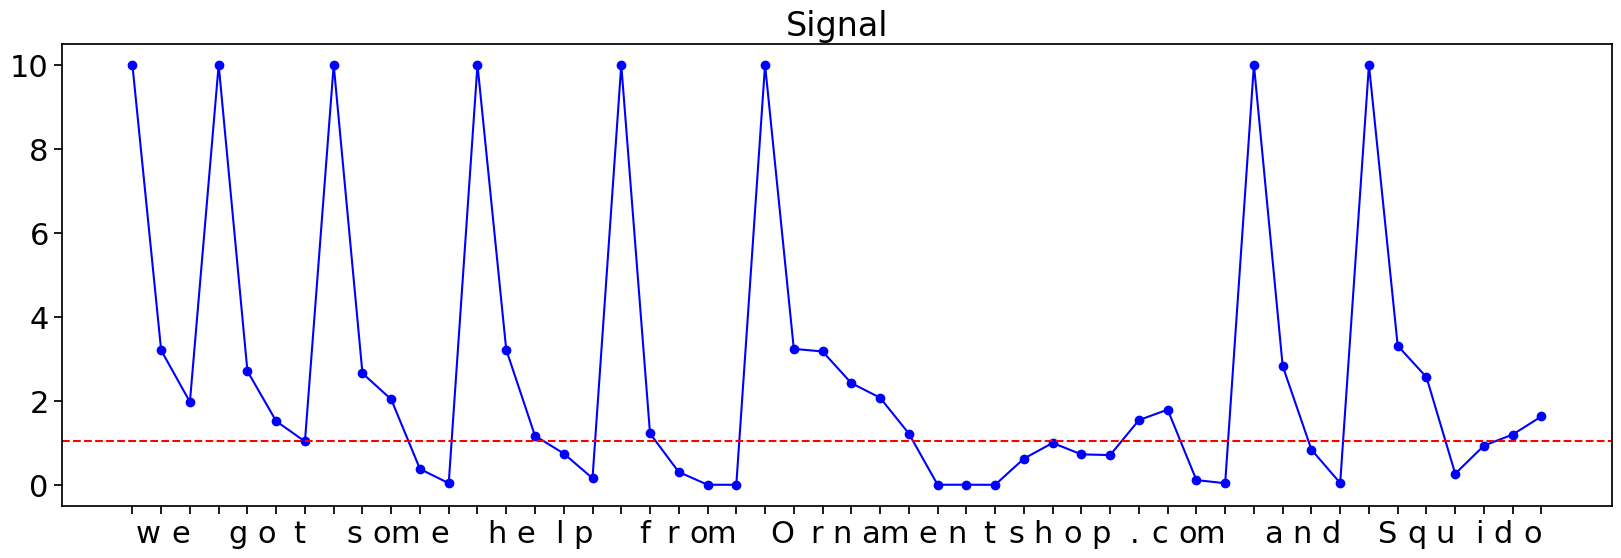

In [79]:
from collections import defaultdict

lim = 50
num_indices = 20

signal = trainer.signal[:lim]
ids = trainer.ids[:lim]
signal[ids == trainer.space_token_id] = 10
tokens = [byte_level_tokenizer.decode([token]) for token in ids]
sorted_indices = torch.argsort(signal)
final_threshold = signal[sorted_indices[num_indices]].item()

plt.figure(figsize=(20, 6))
plt.plot(signal.cpu().numpy(), marker='o', linestyle='-', color='b')
plt.xticks(list(range(lim)), tokens, ha='right')
plt.axhline(y=final_threshold, color='red', linestyle='--')
plt.title("Signal")

left_boundaries = torch.zeros_like(signal, dtype=torch.int64) - 1
right_boundaries = torch.zeros_like(signal, dtype=torch.int64) - 1

total_tokens = len(signal)
discovered_tokens = defaultdict(int)

for i in range(num_indices):
    min_idx = sorted_indices[i]

    if min_idx > 0 and left_boundaries[min_idx-1] != -1:
        left_boundary = left_boundaries[min_idx-1]
    else:
        left_boundary = min_idx
    if min_idx < total_tokens - 1 and right_boundaries[min_idx+1] != -1:
        right_boundary = right_boundaries[min_idx+1]
    else:
        right_boundary = min_idx
    left_boundaries[left_boundary:right_boundary+1] = left_boundary
    right_boundaries[left_boundary:right_boundary+1] = right_boundary

    # Avoid creating Python objects in hot loop
    seg = ids[left_boundary:right_boundary + 1]
    seg_tuple = tuple(seg.tolist())

    token = byte_level_tokenizer.decode(seg)

    is_start = ids[left_boundary-1] == trainer.space_token_id
    token_ref = (bool(is_start), seg_tuple)
    discovered_tokens[token_ref] += 1

    # Decrease counts for the tokens we merged with
    # if left_boundary != min_idx:
    #     prev_token_ref = (bool(is_start), tuple(ids[left_boundary:min_idx].tolist()))
    #     discovered_tokens[prev_token_ref] = max(0, discovered_tokens[prev_token_ref] - 1)
    # if right_boundary != min_idx:
    #     next_token_ref = (False, tuple(ids[min_idx + 1:right_boundary + 1].tolist()))
    #     discovered_tokens[next_token_ref] = max(0, discovered_tokens[next_token_ref] - 1)

final_vocab = []
for token_ref, count in discovered_tokens.items():
    if count < 1:
        continue
    is_start_of_word, token_ids = token_ref
    token = byte_level_tokenizer.decode(token_ids)
    if not is_start_of_word:
        token = "##" + token
    final_vocab.append((token, count))

print(final_vocab)


In [41]:
print(left_boundaries.tolist())
print(right_boundaries.tolist())
print([byte_tokenizer.decode(id) for id in ids])

[-1, -1, -1, -1, -1, -1, 6, -1, -1, 9, 9, 9, -1, -1, -1, 15, -1, -1, 18, 18, 18, 18, -1, -1, -1, -1, -1, 27, 27, 27, 27, -1, -1, 33, -1, -1, 36, 36, -1, -1, -1, 41, 41, -1, -1, 45, -1, -1, -1, 49]
[-1, -1, -1, -1, -1, -1, 6, -1, -1, 11, 11, 11, -1, -1, -1, 15, -1, -1, 21, 21, 21, 21, -1, -1, -1, -1, -1, 30, 30, 30, 30, -1, -1, 33, -1, -1, 37, 37, -1, -1, -1, 42, 42, -1, -1, 45, -1, -1, -1, 49]
[' ', 'w', 'e', ' ', 'g', 'o', 't', ' ', 's', 'o', 'm', 'e', ' ', 'h', 'e', 'l', 'p', ' ', 'f', 'r', 'o', 'm', ' ', 'O', 'r', 'n', 'a', 'm', 'e', 'n', 't', 's', 'h', 'o', 'p', '.', 'c', 'o', 'm', ' ', 'a', 'n', 'd', ' ', 'S', 'q', 'u', 'i', 'd', 'o']


In [60]:
from tqdm import tqdm

def get_vocab_from_threshold(threshold):
    valid_mask = signal < threshold
    change = valid_mask[1:] != valid_mask[:-1]
    change_indices = torch.nonzero(change, as_tuple=False).squeeze(1) + 1
    segment_boundaries = torch.cat([
            torch.tensor([0], device=change.device),
            change_indices,
            torch.tensor([len(signal)], device=change.device)
        ])
    discovered_vocab = defaultdict(int)

    start_index = 0 if valid_mask[0] else 1
    for i in range(start_index, len(segment_boundaries)-1, 2):
        start = segment_boundaries[i].item()
        end = segment_boundaries[i + 1].item()
        segment_ids = tuple(ids[start:end].tolist())

        if len(segment_ids) == 0:
            continue

        if not start_of_word[start]:
            token_ref = (False, segment_ids)
        else:
            token_ref = (True, segment_ids)

        discovered_vocab[token_ref] += 1
    return discovered_vocab

def add_discovered_items_to_vocab(discovered, old_vocab):
    new_vocab = old_vocab.copy()
    discovered = sorted(discovered.items(), key=lambda x: x[1], reverse=True)
    for token_ref, count in discovered:
        if count < 20:
            break
        is_start_of_word, token_ids = token_ref
        token = byte_level_tokenizer.decode(token_ids)
        if not is_start_of_word:
            token = "##" + token
        if not token in new_vocab:
            new_vocab[token] = len(new_vocab)
    return new_vocab

def incremental_threshold_raise(final_vocab_size=1000, keep_intermediate_vocab=False):

    # Track the left and right boundaries of the segments
    left_boundaries = torch.zeros_like(signal, dtype=torch.int64) - 1
    right_boundaries = torch.zeros_like(signal, dtype=torch.int64) - 1

    total_tokens = len(signal)
    discovered_tokens = defaultdict(int)

    stats = pd.DataFrame(columns=["num_moves", "vocab_size", "unique_segments", "threshold"])

    # Initialize tqdm progress bar
    pbar = tqdm(total=final_vocab_size, desc="Building vocabulary", unit="items", dynamic_ncols=True)

    for i in range(total_tokens):
        min_idx = sorted_indices[i]

        # Update left and right boundaries
        if min_idx > 0 and left_boundaries[min_idx-1] != -1:
            left_boundary = left_boundaries[min_idx-1]
        else:
            left_boundary = min_idx
        if min_idx < total_tokens - 1 and right_boundaries[min_idx+1] != -1:
            right_boundary = right_boundaries[min_idx+1]
        else:
            right_boundary = min_idx
        # Might only need left_boundaries[right_boundary] = left_boundary 
        # and right_boundaries[left_boundary] = right_boundary 
        # since we only every check the edges of segments 
        left_boundaries[left_boundary:right_boundary+1] = left_boundary
        right_boundaries[left_boundary:right_boundary+1] = right_boundary

        # Create hashable subword
        seg = ids[left_boundary:right_boundary + 1]
        seg_tuple = tuple(seg.tolist())
        is_start = ids[left_boundary-1] == trainer.space_token_id
        token_ref = (bool(is_start), seg_tuple)

        discovered_tokens[token_ref] += 1

        if not keep_intermediate_vocab:
            # Decrease counts for the tokens we merged with
            if left_boundary != min_idx:
                prev_token_ref = (bool(is_start), tuple(ids[left_boundary:min_idx].tolist()))
                discovered_tokens[prev_token_ref] = max(0, discovered_tokens[prev_token_ref] - 1)
            if right_boundary != min_idx:
                next_token_ref = (False, tuple(ids[min_idx + 1:right_boundary + 1].tolist()))
                discovered_tokens[next_token_ref] = max(0, discovered_tokens[next_token_ref] - 1)

        if i % 1000 == 0:
            vocab = add_discovered_items_to_vocab(discovered_tokens, trainer.vocab)
            vocab_size = len(vocab)
            unique_segments = len(discovered_tokens)
            stats = pd.concat(
                [stats, pd.DataFrame([[i, vocab_size, unique_segments, signal[sorted_indices[i]].item()]], columns=stats.columns)],
                ignore_index=True
            )
            # print(f"Step {i}: Vocab size: {vocab_size}, Unique segments: {unique_segments}, Threshold: {signal[sorted_indices[i]].item()}")

            pbar.update(vocab_size - pbar.n)

            if vocab_size > final_vocab_size:
                print(f"Final vocab size {vocab_size} exceeds target {final_vocab_size}.")
                print("Filtering discovered tokens by frequency.")
                vocab = {k : v for k, v in vocab.items() if v < final_vocab_size}
                vocab_size = len(vocab)
            if vocab_size >= final_vocab_size:
                print(f"Final vocab size reached: {vocab_size}")
                return vocab, stats

In [ ]:
threshold = signal[sorted_indices[1000000]].item()
discovered = get_vocab_from_threshold(threshold)
final_vocab = add_discovered_items_to_vocab(discovered, trainer.vocab)

print(final_vocab)
print(len(final_vocab))

print(len(discovered))

In [61]:
vocab, stats = incremental_threshold_raise(520, keep_intermediate_vocab=True)

Building vocabulary:   0%|          | 0/520 [00:00<?, ?token/s]/tmp/ipykernel_2278381/763476491.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats = pd.concat(
Building vocabulary: 100%|█████████▉| 518/520 [00:28<00:00, 11.57token/s]  

Final vocab size reached: 520


Building vocabulary: 100%|██████████| 520/520 [00:35<00:00, 14.68token/s]


In [17]:
signal_length = len(signal)
vocab_sizes = []
limited_sizes = []
percentages = list(range(0, 96, 1))

final_vocab = trainer.vocab.copy()

for percentage in percentages:
    print(f"Percentage: {percentage}")
    index = int(percentage / 100 * signal_length)
    threshold = signal[sorted_indices[index]].item()
    discovered = get_vocab_from_threshold(threshold)
    final_vocab = add_discovered_items_to_vocab(discovered, final_vocab)
    limited_sizes.append(len(final_vocab))
    vocab_sizes.append(len(discovered))
    print(f"  Discovered: {len(discovered)}")
    print(f"  Final vocab size: {len(final_vocab)}")

Percentage: 0
  Discovered: 0
  Final vocab size: 515
Percentage: 1
  Discovered: 182
  Final vocab size: 529
Percentage: 2
  Discovered: 339
  Final vocab size: 575
Percentage: 3
  Discovered: 506
  Final vocab size: 605
Percentage: 4
  Discovered: 731
  Final vocab size: 645
Percentage: 5
  Discovered: 1007
  Final vocab size: 681
Percentage: 6
  Discovered: 1292
  Final vocab size: 725
Percentage: 7
  Discovered: 1625
  Final vocab size: 765
Percentage: 8
  Discovered: 1999
  Final vocab size: 814
Percentage: 9
  Discovered: 2444
  Final vocab size: 877
Percentage: 10
  Discovered: 2911
  Final vocab size: 921
Percentage: 11
  Discovered: 3467
  Final vocab size: 1003
Percentage: 12
  Discovered: 3979
  Final vocab size: 1059
Percentage: 13
  Discovered: 4544
  Final vocab size: 1125
Percentage: 14
  Discovered: 5191
  Final vocab size: 1205
Percentage: 15
  Discovered: 5830
  Final vocab size: 1264
Percentage: 16
  Discovered: 6464
  Final vocab size: 1341
Percentage: 17
  Discover

KeyboardInterrupt: 

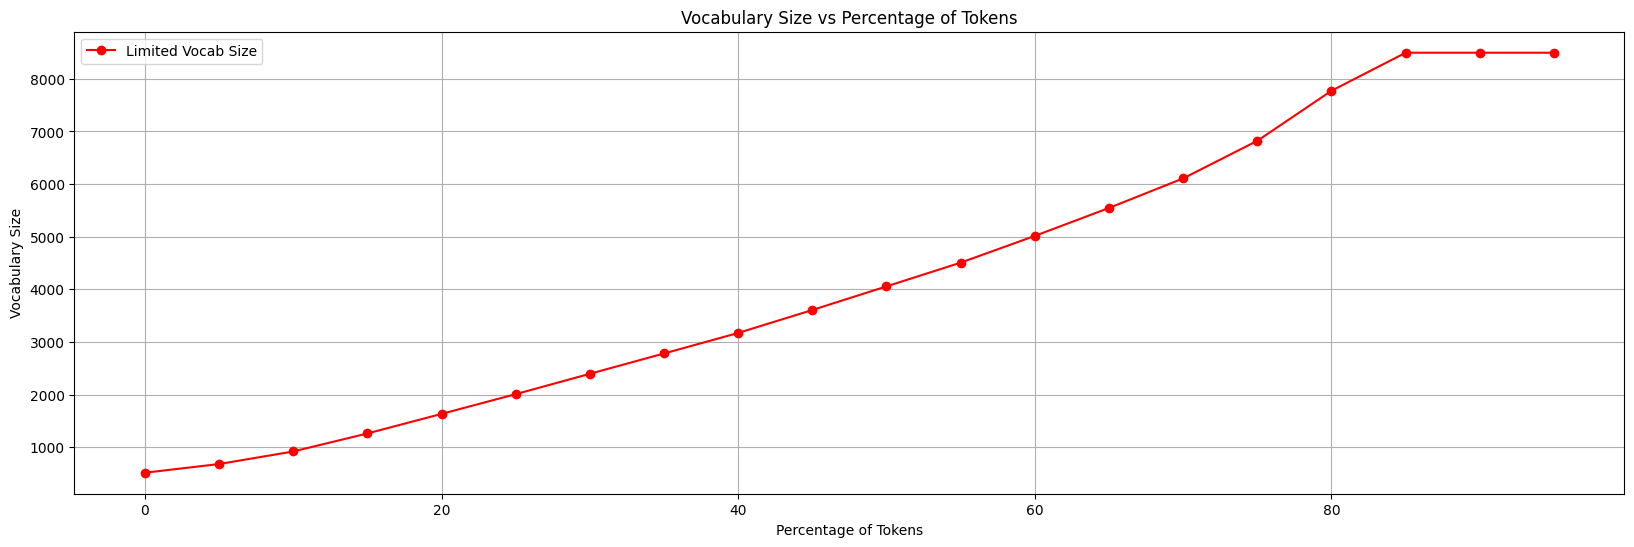

In [16]:
# Plot the results
plt.figure(figsize=(20, 6))
#plt.plot(percentages[:-1], vocab_sizes, marker='o', linestyle='-', color='b', label='Discovered Vocab Size')
plt.plot(percentages, limited_sizes, marker='o', linestyle='-', color='r', label='Limited Vocab Size')
plt.xlabel('Percentage of Tokens')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size vs Percentage of Tokens')
plt.legend()
plt.grid()
plt.show()